In [56]:
import re
import random
import pandas as pd
import hashlib

In [57]:
with open('certcards2.txt', mode='r', encoding='utf8') as f:
    all_cards = f.read()
    
card_split_pattern = r'\n\n\n\d+\n'
all_cards = re.split(card_split_pattern, all_cards)
# Use re.DOTALL to allow . to match newline characters
card_pattern = re.compile(r'(.+?)\n([\s\S]+)', re.DOTALL)
cards = [(match.group(1), match.group(2)) for cstring in all_cards if (match := re.search(card_pattern, cstring))]

# removing the cards that have no content and trimming
cards = [(subject, stripped_content) for subject, content in cards if len(stripped_content := content.strip()) > 5]

def hash_string_md5(s):
    """
    Hashes a string using MD5 and returns a truncated hash for efficiency.

    Parameters:
    - s (str): The input string to hash.

    Returns:
    - str: The truncated hexadecimal hash string.
    """
    if pd.isnull(s):
        return None  # Handle NaN values gracefully
    return hashlib.md5(s.encode('utf-8')).hexdigest()


def remake_card_document(existing_cards: pd.DataFrame, filename: str='certcards2.txt'):
    with open(filename, mode='w', encoding='utf8') as f:
        i = 1
        for _, row in existing_cards.iterrows():
            f.write('\n'*6)
            f.write(str(i)+'\n')  
            f.write(row['head']+'\n')
            f.write(row['body'])
            i+=1
    print(F"Cards found: {existing_cards.shape[0]}")


existing_cards = pd.DataFrame(cards, columns=['head', 'body'])


# existing_cards['age'] = [random.random() for _ in existing_cards.index]
existing_cards['hash'] = existing_cards['body'].apply(hash_string_md5)
existing_cards

card_ages = pd.read_json('card_ages.json')
card_ages = card_ages.drop_duplicates(subset=['hash'], keep='first')

cards_to_age = pd.merge(
    left=existing_cards,
    right=card_ages[['hash', 'age']],
    left_on='hash', right_on='hash',
    how='left'
)

cards_to_age['head'] = cards_to_age['head'].str.strip()

if cards_to_age['age'].sum() > 2e4: age_factor = 1
else: age_factor = 1.00

cards_to_age['age'] = cards_to_age['age'].fillna(0)
cards_to_age['age'] = cards_to_age['age'] * age_factor
cards_to_age['age'] = cards_to_age['age'] + [random.expovariate(.60) for _ in cards_to_age.index]
# cards_to_age['age'] = cards_to_age['age'] * [random.expovariate(.5) for _ in cards_to_age.index]

# Adding priority age growth to cards for upcoming certifications
priority_headers = ['Azure Developer Associate']
priority_cards_mask = cards_to_age['head'].isin(priority_headers)
cards_to_age.loc[priority_cards_mask, 'age'] = cards_to_age.loc[priority_cards_mask, 'age'] * 1.1


cards_to_age = cards_to_age.drop_duplicates(subset=['hash'], keep='first')

cards_to_age['subject_mean_age'] = cards_to_age.groupby('head')['age'].transform('mean')
cards_to_age['subject_highest_age'] = cards_to_age.groupby('head')['age'].transform('max')
cards_to_age['subject_age_sum'] = cards_to_age.groupby('head')['age'].transform('sum')
cards_to_age['head_random_roll'] = cards_to_age.groupby('head')['head'].transform(lambda x: random.random())


cards_to_age.sort_values('hash')[['age', 'head', 'hash']].to_json('card_ages.json', indent=2)

existing_cards = cards_to_age

In [58]:
stats = existing_cards.groupby('head').agg({'age': ['sum', 'mean', 'max'], 'head': 'count'}).sort_values(('age', 'sum'))
stats.columns = stats.columns.to_flat_index()
stats.columns = ['_'.join(col).strip() for col in stats.columns]
stats.index.name = None
stats

,age_sum,age_mean,age_max,head_count
PEP 8,282.709347,94.236449,114.560108,3
Azure Developer Associate,320.002528,7.441919,29.332527,43
Python,970.434311,20.647539,31.103004,47
Todd Ideas,1119.637665,74.642511,160.318233,15
Email Auth and Security,1565.290165,130.440847,491.168774,12
OData,1777.747886,296.291314,572.735431,6
SharePoint,1826.609967,152.217497,592.678162,12
Audit Report Tracker (Sharepoint List),1948.659664,149.896897,382.623050,13
Azure Functions + Visual Studio,2118.448061,151.317719,494.971824,14
Debugging in VS Code,2155.095756,107.754788,273.766319,20


# Histogram

80726.19


<Axes: >

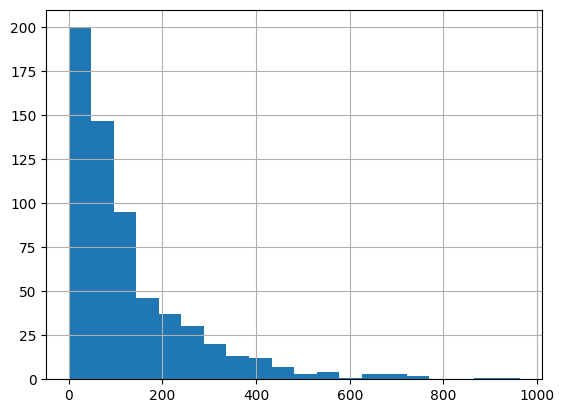

In [59]:
print(f"{existing_cards['age'].sum(0):.2f}")
existing_cards['age'].hist(bins=20)

# Completely Random Shuffle

In [60]:
# existing_cards = existing_cards.sample(frac=1)
# remake_card_document(filename='certcards2.txt', existing_cards = existing_cards)

# Age Sort

In [61]:
# existing_cards = existing_cards.sort_values('age', ascending=False)
# remake_card_document(filename='certcards2.txt', existing_cards=existing_cards)
# existing_cards.head(10)

# Headers with fewest notes first

In [62]:
# frequency = existing_cards['head'].value_counts(ascending=True)

# existing_cards = pd.merge(
#     left=existing_cards,
#     right=frequency.rename('frequency'),
#     left_on='head', right_index=True,
#     how='left'
# )
# existing_cards['oldest'] = existing_cards.groupby('head')['age'].transform('max')
# existing_cards['subject_highest_age'] = existing_cards['subject_highest_age'] * -1
# existing_cards['age'] = existing_cards['age'] * -1


# existing_cards.sort_values(['frequency', 'subject_highest_age', 'age'], ascending=True, inplace=True)

# remake_card_document(filename='certcards2.txt', existing_cards=existing_cards)

# existing_cards.head(10)

# Focus on one header

In [63]:
# heads = existing_cards['head'].value_counts()
# heads = heads[heads > 5].index.tolist()
# one_header = random.sample(heads, 1)[0]
# existing_cards['pick_head'] = existing_cards['head'].apply(
#     lambda h: 0 if h == one_header else 1 
# )

# remake_card_document(existing_cards=existing_cards.sort_values('pick_head'))

## Header with oldest cards first

In [64]:
# existing_cards['oldest'] = existing_cards.groupby('head')['age'].transform('max')
# existing_cards.sort_values(['oldest', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)

## Headers with greatest mean card age first

In [65]:
# existing_cards.sort_values(['subject_mean_age', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)

## Headers with greatest age sum first

In [66]:
# existing_cards.sort_values(['subject_age_sum', 'age'], ascending=False, inplace=True)
# remake_card_document(existing_cards)

# N-fold shuffle


## Age Sum

In [67]:
# n=3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n

# existing_cards['subject_age_sum'] = existing_cards['subject_age_sum'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_age_sum', 'age'], inplace=True)

# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)


## Age Mean

In [68]:
# n=3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n

# existing_cards['subject_mean_age'] = existing_cards['subject_mean_age'] *-1
# existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_mean_age', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)

# existing_cards.head(10)



## Age Max

In [69]:
# n = 1
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] // n

# if existing_cards['age'].sum() > 0:
#     existing_cards['subject_highest_age'] = existing_cards['subject_highest_age'] *-1
#     existing_cards['age'] = existing_cards['age'] *-1
# existing_cards.sort_values(['n_fold', 'subject_highest_age', 'age'], inplace=True)

# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)


## Card Count

In [70]:
n=10
existing_cards['frequency']  = existing_cards.groupby('head').transform('count')['body']
existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
existing_cards['n_fold'] = existing_cards['count'] // n

if existing_cards['age'].sum() > 0:
    # existing_cards['neg_subject_highest_age'] = existing_cards['subject_highest_age'] *-1
    existing_cards['neg_age'] = existing_cards['age'] *-1
existing_cards.sort_values(['n_fold', 'frequency', 'neg_age'], inplace=True)
remake_card_document(existing_cards=existing_cards)

existing_cards.head(10)



Cards found: 625


,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,frequency,count,n_fold,neg_age
0,PEP 8,Use __all__ to Define Public API: In your modu...,2fdee4bd7881c19b937404d853fbd376,114.560108,94.236449,114.560108,282.709347,0.736759,3,0,0,-114.560108
1,PEP 8,"Spaces After Commas, Colons, and Semicolons: I...",7efbfc9eed110ef3e7e7d828bff9ea67,93.035800,94.236449,114.560108,282.709347,0.736759,3,1,0,-93.035800
2,PEP 8,Alias Imports Judiciously: Use the as keyword ...,cf88b4578103db28cd6bd5ceae73624f,75.113440,94.236449,114.560108,282.709347,0.736759,3,2,0,-75.113440
3,OData,Namespaces\n\nDefinition: Unique identifiers (...,c37dc59fe7d7fe68df3c7d713fa0d170,572.735431,296.291314,572.735431,1777.747886,0.871812,6,0,0,-572.735431
4,OData,I found the workflows (actions and functions) ...,2db89204c821bead540580dbf2a8686c,446.550787,296.291314,572.735431,1777.747886,0.871812,6,1,0,-446.550787
5,OData,Type Casting converts an entity from one type ...,0dde439ad1603e99bed556c4b3ccf4fb,290.263358,296.291314,572.735431,1777.747886,0.871812,6,2,0,-290.263358
6,OData,The set of annotations defined within a schema...,5321c4569cf1b65bf960d41e6662109c,232.393383,296.291314,572.735431,1777.747886,0.871812,6,3,0,-232.393383
7,OData,Instance annotations can be used to define add...,675d21da61e0a741941229eee5818559,166.451280,296.291314,572.735431,1777.747886,0.871812,6,4,0,-166.451280
8,OData,Actions and Functions extend the set of operat...,5bf14425855bc24f2c16f4a0d5bc9df8,69.353646,296.291314,572.735431,1777.747886,0.871812,6,5,0,-69.353646
9,Azure Functions,2. Suppose your Azure Function has a blob trig...,fc5054fcf13b3189012cf676692c4f29,762.187382,276.723899,762.187382,3043.962890,0.443894,11,0,0,-762.187382



## Random

In [71]:
# n = 3
# existing_cards['count'] = existing_cards.sort_values('age', ascending=False).groupby('head').cumcount()
# existing_cards['n_fold'] = existing_cards['count'] % n
# existing_cards['age'] *= -1
# existing_cards.sort_values(['n_fold', 'head_random_roll', 'age'], inplace=True)
# remake_card_document(existing_cards=existing_cards)
# existing_cards.head(10)

In [72]:
existing_cards.head(10)

,head,body,hash,age,subject_mean_age,subject_highest_age,subject_age_sum,head_random_roll,frequency,count,n_fold,neg_age
0,PEP 8,Use __all__ to Define Public API: In your modu...,2fdee4bd7881c19b937404d853fbd376,114.560108,94.236449,114.560108,282.709347,0.736759,3,0,0,-114.560108
1,PEP 8,"Spaces After Commas, Colons, and Semicolons: I...",7efbfc9eed110ef3e7e7d828bff9ea67,93.035800,94.236449,114.560108,282.709347,0.736759,3,1,0,-93.035800
2,PEP 8,Alias Imports Judiciously: Use the as keyword ...,cf88b4578103db28cd6bd5ceae73624f,75.113440,94.236449,114.560108,282.709347,0.736759,3,2,0,-75.113440
3,OData,Namespaces\n\nDefinition: Unique identifiers (...,c37dc59fe7d7fe68df3c7d713fa0d170,572.735431,296.291314,572.735431,1777.747886,0.871812,6,0,0,-572.735431
4,OData,I found the workflows (actions and functions) ...,2db89204c821bead540580dbf2a8686c,446.550787,296.291314,572.735431,1777.747886,0.871812,6,1,0,-446.550787
5,OData,Type Casting converts an entity from one type ...,0dde439ad1603e99bed556c4b3ccf4fb,290.263358,296.291314,572.735431,1777.747886,0.871812,6,2,0,-290.263358
6,OData,The set of annotations defined within a schema...,5321c4569cf1b65bf960d41e6662109c,232.393383,296.291314,572.735431,1777.747886,0.871812,6,3,0,-232.393383
7,OData,Instance annotations can be used to define add...,675d21da61e0a741941229eee5818559,166.451280,296.291314,572.735431,1777.747886,0.871812,6,4,0,-166.451280
8,OData,Actions and Functions extend the set of operat...,5bf14425855bc24f2c16f4a0d5bc9df8,69.353646,296.291314,572.735431,1777.747886,0.871812,6,5,0,-69.353646
9,Azure Functions,2. Suppose your Azure Function has a blob trig...,fc5054fcf13b3189012cf676692c4f29,762.187382,276.723899,762.187382,3043.962890,0.443894,11,0,0,-762.187382


In [73]:
existing_cards['age'].mean()

129.16189876064848